# Use Case - Churn Prediction

> Data Mining for Business Analytics ADS-505
>
> Fatemeh Khosravi - Stephen Kuc - Ruddy Simonpour

In [1]:
# import dependencies
import pandas as pd
import numpy as np
import csv
import os
import matplotlib.pylab as plt
import seaborn as sns

import statsmodels.tools.tools as stattools

from sklearn import preprocessing

# models
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB


from dmba.metric import AIC_score

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from dmba.metric import AIC_score
from dmba import classificationSummary, gainsChart, liftChart
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.svm import SVC
import sklearn.metrics as metrics
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
bank = pd.read_csv("Dataset/Bank Customer Churn Prediction.csv",low_memory=False)

In [3]:
# print data
bank.sample(10)

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
9859,15615430,678,Germany,Male,55,4,129646.91,1,1,1,184125.10,1
5133,15668104,479,Spain,Male,37,6,118433.94,1,0,1,160060.90,0
6135,15624611,497,Spain,Male,37,8,128650.11,2,1,1,163641.53,0
173,15586310,578,France,Male,30,4,169462.09,1,1,0,112187.11,0
18,15661507,587,Spain,Male,45,6,0.00,1,0,0,158684.81,0
4149,15621435,623,France,Female,39,1,160903.20,1,0,0,78774.36,0
2351,15678284,651,France,Male,35,7,74623.50,3,1,0,129451.29,1
330,15598493,656,France,Male,50,7,0.00,2,0,1,72143.44,0
3852,15639669,746,France,Male,36,9,127157.04,1,1,1,155700.15,0
1467,15681843,624,Germany,Female,35,0,180303.24,2,1,0,163587.90,0


In [4]:
# checking the data types
bank.dtypes

customer_id           int64
credit_score          int64
country              object
gender               object
age                   int64
tenure                int64
balance             float64
products_number       int64
credit_card           int64
active_member         int64
estimated_salary    float64
churn                 int64
dtype: object

In [5]:
# dataframe shape
print(f'Number of rows in the dataframe {bank.shape[0]}')
print(f'Number of columns in the dataframe {bank.shape[1]}')

Number of rows in the dataframe 10000
Number of columns in the dataframe 12


In [6]:
bank.describe().T

,count,mean,std,min,25%,50%,75%,max
customer_id,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
credit_score,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
tenure,10000.0,5.012800e+00,2.892174,0.00,3.00,5.000000e+00,7.000000e+00,10.00
balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
products_number,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
credit_card,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
active_member,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
estimated_salary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48
churn,10000.0,2.037000e-01,0.402769,0.00,0.00,0.000000e+00,0.000000e+00,1.00


For binary variables, incl target:

Churn: ~20.4% positive records CC: ~70.5% positive active member: ~51.5% positive

For numerical:

cc: seems about symmetrical (median ~= mean); ranges from 350 - 850

age: 18 - 92; slightly skewed right, with mean of 38.9 and median of 37.

tenure: seems symmetrical; anywhere from 0 years to 10 years.

balance: ranges from  0𝑡𝑜 250k. The median > mean (~97k vs 76k), so it is skewed left

estimated salary: mean / median both around 100k. ranges from 57.5k to ~200k.

### Missing values

In [7]:
# checking for missing values
bank.isnull().sum()

customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

There is no missing values in the dataset

### Duplicated Rows

In [8]:
# checking for duplicated values
duplicate_values = bank.duplicated().sum()
print(f'The number of duplicated values are : {duplicate_values}')

The number of duplicated values are : 0


In [9]:
# check number of unique values for each column
bank.nunique()

customer_id         10000
credit_score          460
country                 3
gender                  2
age                    70
tenure                 11
balance              6382
products_number         4
credit_card             2
active_member           2
estimated_salary     9999
churn                   2
dtype: int64

There are only 3 different countries and 4 different products. These two we can make into dummy variables. CC and active member are indeed binary. 

### Visualization

Number of No Churn:  7963
Number of Churn :  2037


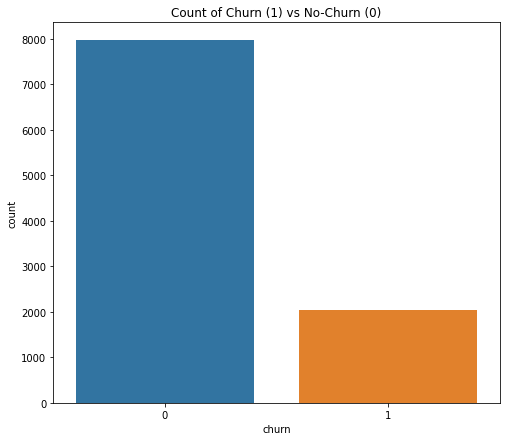

In [10]:
# Bar graph of the target variable (0/1)
plt.figure(figsize = (8,7))
sns.countplot(x="churn", data=bank).set(title='Count of Churn (1) vs No-Churn (0)')

No_Churn, Churn = bank['churn'].value_counts()
print('Number of No Churn: ',No_Churn)
print('Number of Churn : ',Churn)

In [11]:
bank["products_number"].value_counts()

1    5084
2    4590
3     266
4      60
Name: products_number, dtype: int64

The target variable is not balance

### Dummy Variables

There is not missing values and duplicated values in the dataset. Now we can drop unnecessary columns. "Customer-ID"s are assigned at random and are not based on anything. Therefore, we can remove this column

In [12]:
bank_country = pd.get_dummies(bank['country'], prefix = 'country', drop_first = True)
bank_gender= pd.get_dummies(bank['gender'], prefix = 'gender', drop_first = True)

churn_df = bank.drop(['country', 'gender', 'customer_id'], axis = 1)

churn_df = pd.concat([churn_df, bank_country, bank_gender], axis = 1)

churn_df.head()

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,country_Germany,country_Spain,gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


In [13]:
# change the data type of the dummy variables (uint8 --> int64)
def data_type_change(df,cols):
    df[cols]=df[cols].astype(int)
    return df

churn_df = data_type_change(churn_df,["country_Germany","country_Spain",
                                      "gender_Male"])

churn_df.dtypes

credit_score          int64
age                   int64
tenure                int64
balance             float64
products_number       int64
credit_card           int64
active_member         int64
estimated_salary    float64
churn                 int64
country_Germany       int64
country_Spain         int64
gender_Male           int64
dtype: object

### Correlation

<AxesSubplot:>

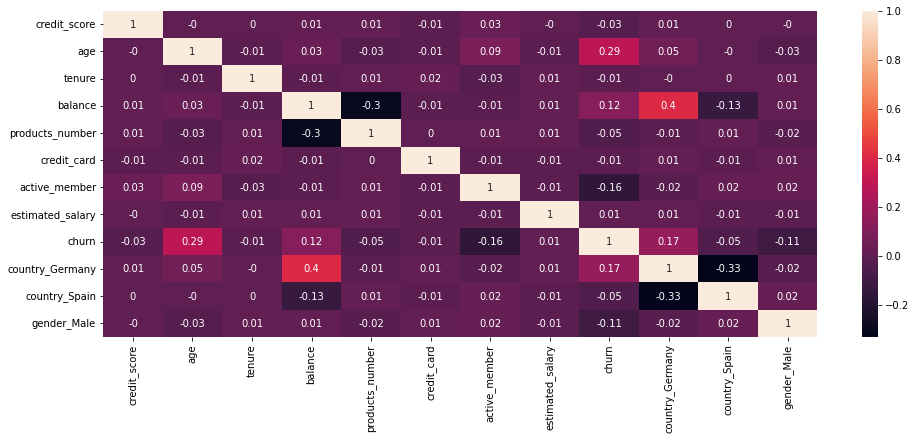

In [14]:
# Correlation matrix
plt.figure(figsize=(16, 6))
sns.heatmap(round(churn_df.corr(),2), annot = True)

highest correlations with churn: age (+.29), country_germany (+.17)

Multi collinearities?

Age -- no, next highest correlation is .09 with active member.

country_Germany -- .4 with balance; -.33 with country_Spain

### Continues variables and Churn

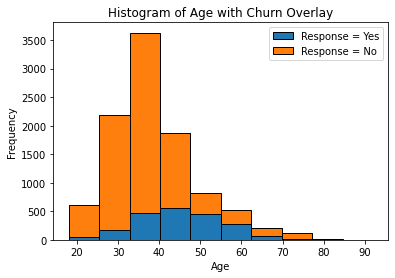

In [15]:
a=bank[bank.churn==1]['age']
b=bank[bank.churn==0]['age']
(n,bins,patches) = plt.hist([a, b], edgecolor='black',bins = 10, stacked = True)
plt.legend(['Response = Yes', 'Response = No']) 
plt.title('Histogram of Age with Churn Overlay')
plt.xlabel('Age')
plt.ylabel('Frequency') 
plt.show()


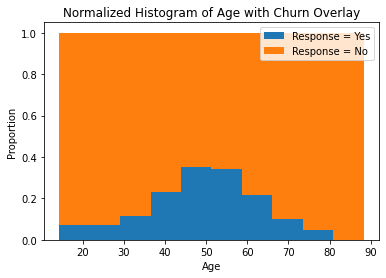

In [16]:
n_table = np.column_stack((n[0],n[1]))
n_norm = n_table/n_table.sum(axis=1)[:,None] 
ourbins = np.column_stack((bins[0:10], bins[1:11])) 
p1=plt.bar(x=ourbins[:,0], height = n_norm[:,0],width = ourbins[:, 1]- ourbins[:, 0])
p2 = plt.bar(x = ourbins[:,0], height = n_norm[:,1],width = ourbins[:, 1] - ourbins[:, 0],bottom = n_norm[:,0]) 
plt.legend(['Response = Yes', 'Response = No'])
plt.title('Normalized Histogram of Age with Churn Overlay') 
plt.xlabel('Age')
plt.ylabel('Proportion')
plt.show()

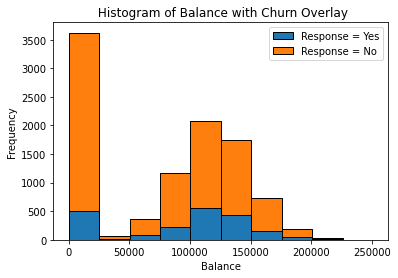

In [17]:
a=bank[bank.churn==1]['balance']
b=bank[bank.churn==0]['balance']
(n,bins,patches) = plt.hist([a, b], edgecolor='black',bins = 10, stacked = True)
plt.legend(['Response = Yes', 'Response = No']) 
plt.title(' Histogram of Balance with Churn Overlay')
plt.xlabel('Balance')
plt.ylabel('Frequency') 
plt.show()

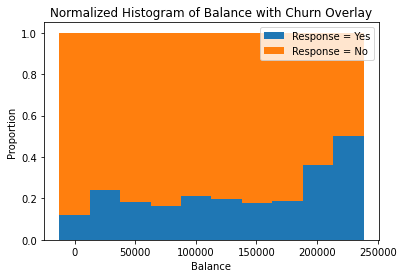

In [18]:
n_table = np.column_stack((n[0],n[1]))
n_norm = n_table/n_table.sum(axis=1)[:,None] 
ourbins = np.column_stack((bins[0:10], bins[1:11])) 
p1=plt.bar(x=ourbins[:,0], height = n_norm[:,0],width = ourbins[:, 1]- ourbins[:, 0])
p2 = plt.bar(x = ourbins[:,0], height = n_norm[:,1],width = ourbins[:, 1] - ourbins[:, 0],bottom = n_norm[:,0]) 
plt.legend(['Response = Yes', 'Response = No'])
plt.title('Normalized Histogram of Balance with Churn Overlay') 
plt.xlabel('Balance')
plt.ylabel('Proportion')
plt.show()

Text(0, 0.5, 'Frequency')

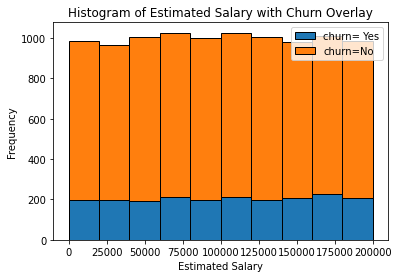

In [19]:
a=bank[bank.churn ==1]['estimated_salary']
b=bank[bank.churn==0]['estimated_salary']
(n,bins,patches) = plt.hist([a, b], edgecolor='black',bins = 10, stacked = True)
plt.legend(['churn= Yes','churn=No'])
plt.title('Histogram of Estimated Salary with Churn Overlay')
plt.xlabel('Estimated Salary')
plt.ylabel('Frequency')

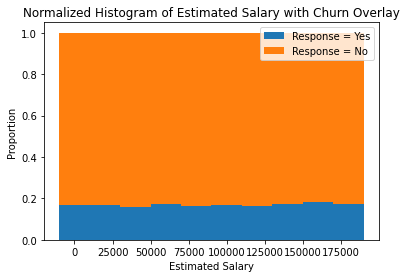

In [20]:
n_table = np.column_stack((n[0],n[1]))
n_norm = n_table/n_table.sum(axis=1)[:,None] 
ourbins = np.column_stack((bins[0:10], bins[1:11])) 
p1=plt.bar(x=ourbins[:,0], height = n_norm[:,0],width = ourbins[:, 1]- ourbins[:, 0])
p2 = plt.bar(x = ourbins[:,0], height = n_norm[:,1],width = ourbins[:, 1] - ourbins[:, 0],bottom = n_norm[:,0]) 
plt.legend(['Response = Yes', 'Response = No'])
plt.title('Normalized Histogram of Estimated Salary with Churn Overlay') 
plt.xlabel('Estimated Salary')
plt.ylabel('Proportion')
plt.show()

Text(0, 0.5, 'Frequency')

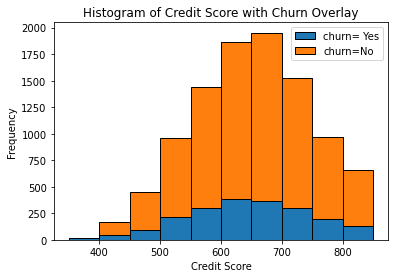

In [21]:
a=bank[bank.churn ==1]['credit_score']
b=bank[bank.churn==0]['credit_score']
(n,bins,patches) = plt.hist([a, b], edgecolor='black',bins = 10, stacked = True)
plt.legend(['churn= Yes','churn=No'])
plt.title('Histogram of Credit Score with Churn Overlay')
plt.xlabel('Credit Score')
plt.ylabel('Frequency')

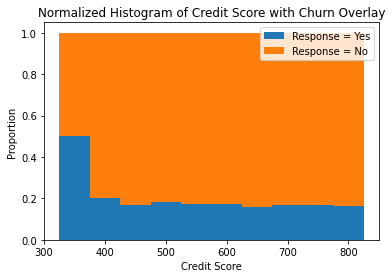

In [22]:
n_table = np.column_stack((n[0],n[1]))
n_norm = n_table/n_table.sum(axis=1)[:,None] 
ourbins = np.column_stack((bins[0:10], bins[1:11])) 
p1=plt.bar(x=ourbins[:,0], height = n_norm[:,0],width = ourbins[:, 1]- ourbins[:, 0])
p2 = plt.bar(x = ourbins[:,0], height = n_norm[:,1],width = ourbins[:, 1] - ourbins[:, 0],bottom = n_norm[:,0]) 
plt.legend(['Response = Yes', 'Response = No'])
plt.title('Normalized Histogram of Credit Score with Churn Overlay') 
plt.xlabel('Credit Score')
plt.ylabel('Proportion')
plt.show()

### Distribution of Numerical Variables

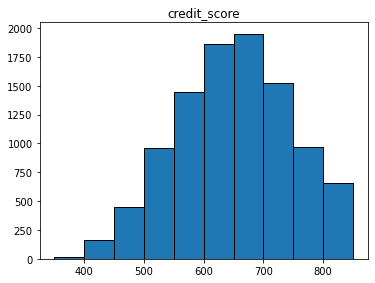

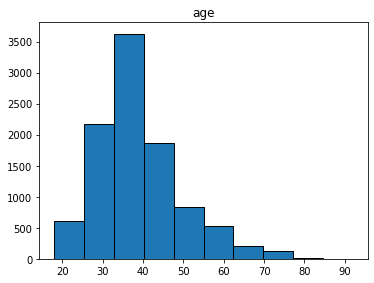

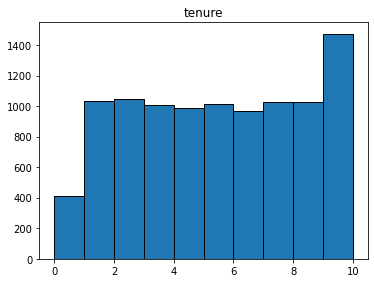

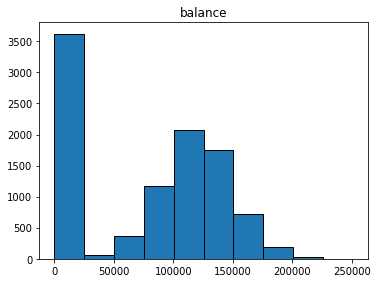

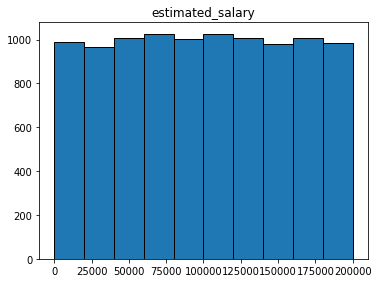

In [23]:
# Visualizing each numerical variables histogram
col=churn_df[['credit_score','age','tenure','balance','estimated_salary']]
for i in col:
  n=1
  plt.figure(figsize=(20,20))
  plt.subplot(4,3,1)
  plt.hist(churn_df[i],edgecolor='black')
  plt.title(i)
  plt.show()
  n=n+1

###  Skewness

In [24]:
# check the skewness
col=churn_df[['credit_score','age','tenure','balance','estimated_salary']]
col.skew()

credit_score       -0.071607
age                 1.011320
tenure              0.010991
balance            -0.141109
estimated_salary    0.002085
dtype: float64

### Log Transformation

Text(0.5, 1.0, 'Log Transformed Age')

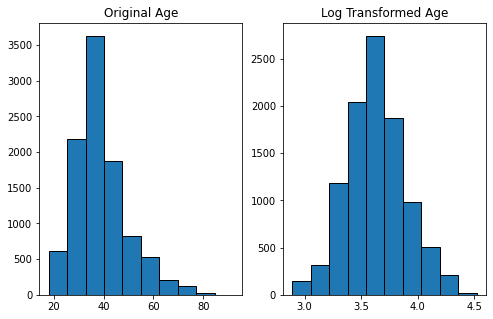

In [25]:
# log transformation for age 
np.random.seed(0)
age_trans = np.log(churn_df['age'])
fig, axs = plt.subplots(nrows=1, ncols=2,figsize=(8,5))
axs[0].hist(churn_df['age'], edgecolor='black')
axs[1].hist(age_trans, edgecolor='black')
axs[0].set_title('Original Age')
axs[1].set_title('Log Transformed Age')

In [26]:
# converting  skewed column to the transformed values
churn_df['age']=age_trans

### Scaling

In [27]:
# for scaling any numerical 

churn_numerical = churn_df[['credit_score','age', 'tenure','balance', 'estimated_salary']]


from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(churn_numerical)

churn_numerical_scaled = scaler.transform(churn_numerical)

churn_numerical_scaled = pd.DataFrame(churn_numerical_scaled, columns = churn_numerical.columns)

churn_numerical_scaled.head()

,credit_score,age,tenure,balance,estimated_salary
0,-0.326221,0.425883,-1.041760,-1.225848,0.021886
1,-0.440036,0.332621,-1.387538,0.117350,0.216534
2,-1.536794,0.425883,1.032908,1.333053,0.240687
3,0.501521,0.139072,-1.387538,-1.225848,-0.108918
4,2.063884,0.516950,-1.041760,0.785728,-0.365276


In [28]:
# We can add these back into the

churn_df_scaled = churn_df.drop(churn_numerical, axis =1)

churn_df_scaled = pd.concat([churn_df_scaled, churn_numerical_scaled], axis = 1)

churn_df_scaled.head(5)

,products_number,credit_card,active_member,churn,country_Germany,country_Spain,gender_Male,credit_score,age,tenure,balance,estimated_salary
0,1,1,1,1,0,0,0,-0.326221,0.425883,-1.041760,-1.225848,0.021886
1,1,0,1,0,0,1,0,-0.440036,0.332621,-1.387538,0.117350,0.216534
2,3,1,0,1,0,0,0,-1.536794,0.425883,1.032908,1.333053,0.240687
3,2,0,0,0,0,0,0,0.501521,0.139072,-1.387538,-1.225848,-0.108918
4,1,1,1,0,0,1,0,2.063884,0.516950,-1.041760,0.785728,-0.365276


### Outliers

<AxesSubplot:xlabel='estimated_salary'>

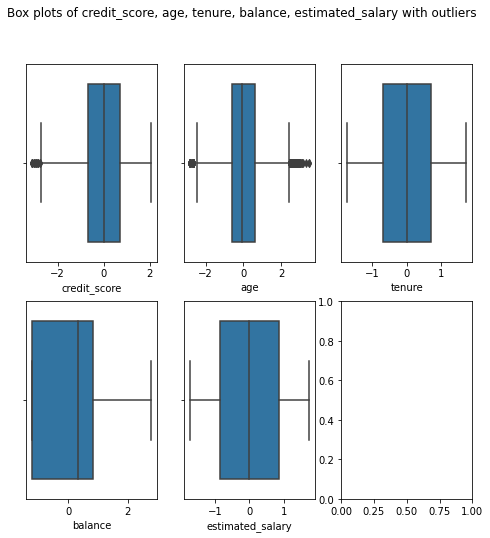

In [29]:
fig, axes = plt.subplots(2,3, figsize=(8,8))
plt.suptitle('Box plots of credit_score, age, tenure, balance, estimated_salary with outliers')

sns.boxplot(churn_df_scaled['credit_score'],ax=axes[0,0])
sns.boxplot(churn_df_scaled['age'],ax=axes[0,1])
sns.boxplot(churn_df_scaled['tenure'],ax=axes[0,2])
sns.boxplot(churn_df_scaled['balance'],ax=axes[1,0])
sns.boxplot(churn_df_scaled['estimated_salary'],ax=axes[1,1])

In [30]:
#Boxplot WITH outliers
numeric_columns= ['credit_score','age','tenure','balance','estimated_salary']
for col_name in numeric_columns:
  print('feature: ', col_name)
  

  #IQR
  Q1 = churn_df_scaled[col_name].quantile(0.25)
  Q3 = churn_df_scaled[col_name].quantile(0.75)
  IQR = Q3-Q1

  mean1 = round(churn_df_scaled[col_name].mean(),2)
  std1 = round(churn_df_scaled[col_name].std(),2)
  median1 = round(churn_df_scaled[col_name].median(),2)
  churn_df_scaled = churn_df_scaled[(churn_df_scaled[col_name] > (Q1 - 1.5 * IQR)) & (churn_df_scaled[col_name] < (Q3 + 1.5 * IQR))]

feature:  credit_score
feature:  age
feature:  tenure
feature:  balance
feature:  estimated_salary


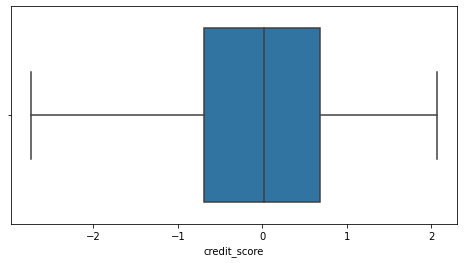

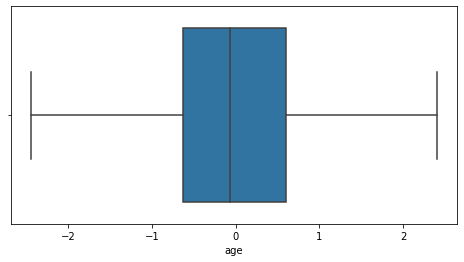

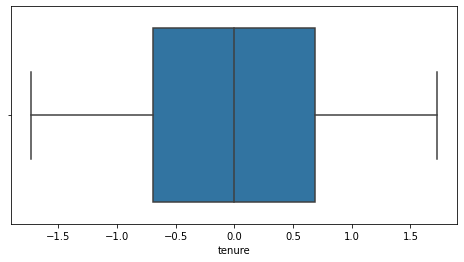

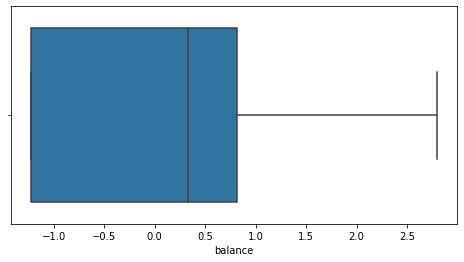

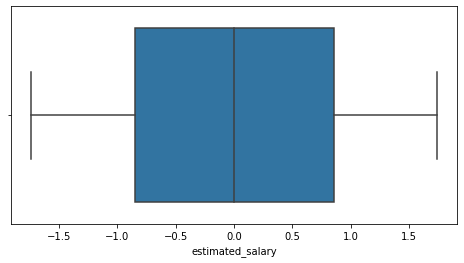

In [31]:
#Boxplot WITHOUT outliers
numeric_columns= ['credit_score','age','tenure','balance','estimated_salary'] 
for col_name in numeric_columns:
  plt.figure(figsize = (8,4))
  sns.boxplot(x = churn_df_scaled[col_name])

In [32]:
churn_df_scaled.shape

(9802, 12)

The number of 198 samples were removed from the data.

### Imbalance dataset

In [33]:
churn_df_scaled['churn'].value_counts()/churn_df_scaled.shape[0]

0    0.795246
1    0.204754
Name: churn, dtype: float64

In [34]:
# splitting into X and Y

X = churn_df_scaled.drop('churn', axis = 1)
y = churn_df_scaled['churn']

In [35]:
churn_df_scaled['churn'].value_counts()

0    7795
1    2007
Name: churn, dtype: int64

### SMOTE
!pip install imbalanced-learn

In [36]:
smote = SMOTE(sampling_strategy='minority',random_state=0)
X_smt, y_smt = smote.fit_resample(X,y)

y_smt.value_counts()

1    7795
0    7795
Name: churn, dtype: int64

### Train-Test Spliting

In [37]:
# partitioning data into 90% train and 10% test, and then will further split for validation

trainX, testX, trainy, testy = train_test_split(X_smt, y_smt, test_size = .1, random_state = 12345)

# using 80 / 20 split for train and validation set

trainX, validX, trainy, validy = train_test_split(trainX, trainy, test_size = .2, random_state = 12345)

In [38]:
print("Test set dimensions: ", testX.shape, 
      "\n Train set dimensions: ", trainX.shape,
      "\n Validation set dimension: ", validX.shape)

Test set dimensions:  (1559, 11) 
 Train set dimensions:  (11224, 11) 
 Validation set dimension:  (2807, 11)


## Modeling

### K-NN

We can see the algorithm tends to pick the number of K=1 for the best value of K, and with this value of K we will be overfit on the training data. To avoiding this, we set the value of K for hyperparameters tuning from 3.


In [39]:
# Train a classifier for different values of k
knn_results = []
for k in range(1, 25, 2):
    knn = KNeighborsClassifier(n_neighbors=k).fit(trainX, trainy)
    knn_results.append({
        'k': k,
        'accuracy': accuracy_score(validy, knn.predict(validX)),
        'recall': recall_score(validy, knn.predict(validX)),
        'f1_score': f1_score(validy, knn.predict(validX))
    })

# Convert results to a pandas data frame
knn_results = pd.DataFrame(knn_results)
knn_results

,k,accuracy,recall,f1_score
0,1,0.878874,0.946676,0.889395
1,3,0.862487,0.934211,0.874838
2,5,0.855362,0.918283,0.867233
3,7,0.848949,0.909280,0.860984
4,9,0.841112,0.896814,0.853096
5,11,0.836836,0.880886,0.847435
6,13,0.832561,0.880194,0.843958
7,15,0.833274,0.877424,0.844104
8,17,0.827574,0.863573,0.837475
9,19,0.821874,0.860111,0.832440


Text(0, 0.5, 'Metrics score')

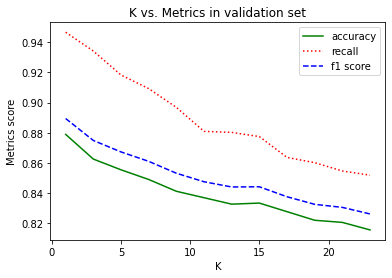

In [40]:
# Plotting K-nn metrics from validation tests

# show accuracy by k
plt.plot(knn_results.k, knn_results.accuracy, linestyle='-', c='green', label = "accuracy")
plt.plot(knn_results.k, knn_results.recall, linestyle=':', c='red', label = "recall")
plt.plot(knn_results.k, knn_results['f1_score'], linestyle='--', c='blue', label = "f1 score")
plt.legend()
plt.title('K vs. Metrics in validation set')
plt.xlabel('K')
plt.ylabel('Metrics score')

In [41]:
# knn and tuning hyperparameters 

grid_parameters = [{
    'n_neighbors': list(range(3,31,1)),
    }]



Knn=GridSearchCV(KNeighborsClassifier(),grid_parameters, cv=5, scoring='accuracy', return_train_score=False,verbose=1)
Knn.fit(trainX, trainy)
knn_clf = Knn.best_estimator_


Fitting 5 folds for each of 28 candidates, totalling 140 fits


In [42]:
#best parameters for KNN classifier
Knn.best_params_


{'n_neighbors': 4}

In [43]:
 # predictive performance on training data 
classificationSummary(trainy, knn_clf.predict(trainX))


Confusion Matrix (Accuracy 0.9223)

       Prediction
Actual    0    1
     0 5157  508
     1  364 5195



 Classification report for Knn \: 
               precision    recall  f1-score   support

           0       0.87      0.85      0.86      1363
           1       0.86      0.88      0.87      1444

    accuracy                           0.86      2807
   macro avg       0.86      0.86      0.86      2807
weighted avg       0.86      0.86      0.86      2807

Area under curve :  0.8616965387171447 



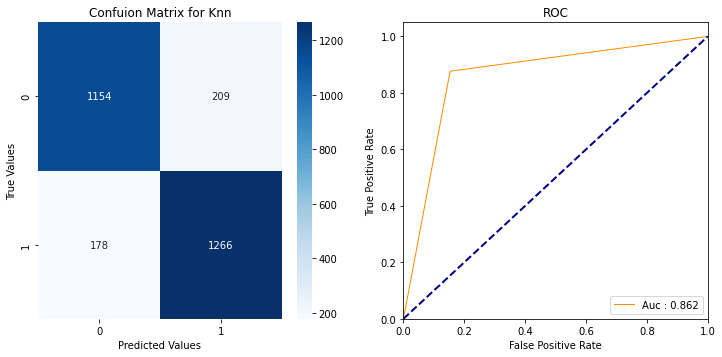

In [44]:
print ("\n Classification report for Knn \: \n",classification_report(validy,knn_clf.predict(validX)))


#confusion matrix
cm = confusion_matrix(validy,knn_clf.predict(validX))
plt.figure(figsize=(12,12))
plt.subplot(221)
sns.heatmap(cm, fmt = "d",annot=True, cmap='Blues')
plt.title('Confuion Matrix for Knn')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')


#roc_auc_score
model_roc_auc = roc_auc_score(validy,knn_clf.predict(validX)) 
print ("Area under curve : ",model_roc_auc,"\n")
fpr,tpr,thresholds = roc_curve(validy,knn_clf.predict(validX))

plt.subplot(222)
plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc : %.3f" %model_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

    
plt.show()

### Random Forest

In [45]:
# Train a classifier for different values of n_estimators
rf_results = []
for x in range(100, 1001, 100):
    rf = RandomForestClassifier(n_estimators = x, random_state = 1).fit(trainX, trainy)
    rf_results.append({'n_estimators': x, 'accuracy': accuracy_score(validy, rf.predict(validX)), 
                      'recall': recall_score(validy, rf.predict(validX)),
                      'f1_score': f1_score(validy, rf.predict(validX))})

    
# Convert results to a pandas data frame
rf_results = pd.DataFrame(rf_results)

Text(0, 0.5, 'Metrics score')

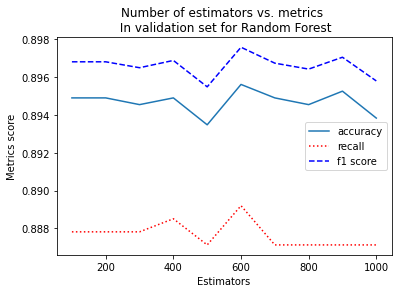

In [46]:
# show accuracy by estimators
plt.plot(rf_results['n_estimators'], rf_results.accuracy, linestyle='-', label = "accuracy")
plt.plot(rf_results['n_estimators'], rf_results.recall, linestyle=':', c='red', label = "recall")
plt.plot(rf_results['n_estimators'], rf_results['f1_score'], linestyle='--', c='blue', label = "f1 score")
plt.title('Number of estimators vs. metrics \n In validation set for Random Forest')
plt.legend()
plt.xlabel('Estimators')
plt.ylabel('Metrics score')

In [47]:
# random forest tuning hyperparameters 

grid_parameters = { 
    'n_estimators': [200,400,600],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}


rf= GridSearchCV(RandomForestClassifier(random_state=42), grid_parameters, cv= 5)
rf=rf.fit(trainX, trainy)
rf_clf=rf.best_estimator_


In [48]:
#best parameters for random forest classifier
rf.best_params_


{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 400}

In [49]:
 # predictive performance on training data 
classificationSummary(trainy, rf_clf.predict(trainX))

Confusion Matrix (Accuracy 0.8498)

       Prediction
Actual    0    1
     0 4940  725
     1  961 4598



 Classification report for Random Forest \: 
               precision    recall  f1-score   support

           0       0.79      0.86      0.83      1363
           1       0.86      0.79      0.82      1444

    accuracy                           0.82      2807
   macro avg       0.83      0.83      0.82      2807
weighted avg       0.83      0.82      0.82      2807

Area under curve :  0.8251199590279711 



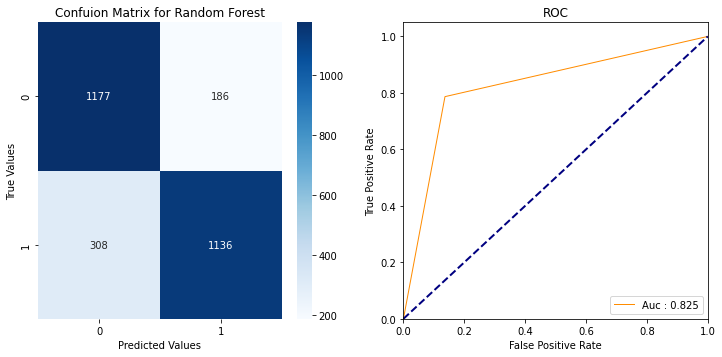

In [50]:
print ("\n Classification report for Random Forest \: \n",classification_report(validy,rf_clf.predict(validX)))


#confusion matrix
cm = confusion_matrix(validy,rf_clf.predict(validX))
plt.figure(figsize=(12,12))
plt.subplot(221)
sns.heatmap(cm, fmt = "d",annot=True, cmap='Blues')
plt.title('Confuion Matrix for Random Forest')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')


#roc_auc_score
model_roc_auc = roc_auc_score(validy,rf_clf.predict(validX)) 
print ("Area under curve : ",model_roc_auc,"\n")
fpr,tpr,thresholds = roc_curve(validy,rf_clf.predict(validX))

plt.subplot(222)
plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc : %.3f" %model_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

    
plt.show()

### Decision Tree

In [51]:
dt_results = []
criterion = ["gini", "entropy"]

for x in criterion:
    dt = DecisionTreeClassifier(criterion = x, random_state = 1).fit(trainX, trainy)
    dt_results.append({'criterion': x, 'accuracy': accuracy_score(validy, dt.predict(validX)), 
                      'recall': recall_score(validy, dt.predict(validX)),
                      'f1_score': f1_score(validy, dt.predict(validX))})
    

# Convert results to a pandas data frame
dt_results = pd.DataFrame(dt_results)

In [52]:
dt_results.sort_values(by=["accuracy"],ascending=False)

,criterion,accuracy,recall,f1_score
0,gini,0.820449,0.835180,0.827160
1,entropy,0.820093,0.817175,0.823735


In [53]:
dt_results_depth = []

for x in range(2, 30, 2):
    dt = DecisionTreeClassifier(max_depth = x, criterion = "entropy", random_state = 1).fit(trainX, trainy)
    dt_results_depth.append({'max_depth': x, 'accuracy': accuracy_score(validy, dt.predict(validX)), 
                      'recall': recall_score(validy, dt.predict(validX)),
                      'f1_score': f1_score(validy, dt.predict(validX))})
dt_results_depth = pd.DataFrame(dt_results_depth)

In [54]:
dt_results_depth

,max_depth,accuracy,recall,f1_score
0,2,0.732811,0.681440,0.724062
1,4,0.762024,0.822022,0.780408
2,6,0.791236,0.785319,0.794674
3,8,0.797292,0.755540,0.793166
4,10,0.796580,0.757618,0.793041
5,12,0.801211,0.785319,0.802548
6,14,0.799786,0.786011,0.801554
7,16,0.808693,0.806787,0.812696
8,18,0.815461,0.804017,0.817606
9,20,0.818311,0.808864,0.820801


Text(0, 0.5, 'Metrics score')

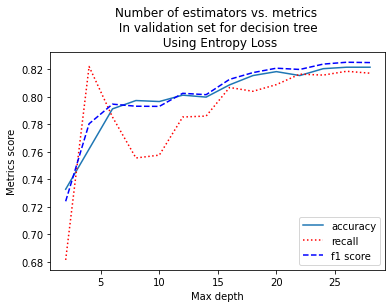

In [55]:
# show accuracy by depth
plt.plot(dt_results_depth['max_depth'], dt_results_depth.accuracy, linestyle='-', label = "accuracy")
plt.plot(dt_results_depth['max_depth'], dt_results_depth.recall, linestyle=':', c='red', label = "recall")
plt.plot(dt_results_depth['max_depth'], dt_results_depth['f1_score'], linestyle='--', c='blue', label = "f1 score")
plt.title('Number of estimators vs. metrics \n In validation set for decision tree \n Using Entropy Loss')
plt.legend()
plt.xlabel('Max depth')
plt.ylabel('Metrics score')

In [56]:
# decisin tree tuning hyperparameters

# initial guess for parameters
grid_parameters = {
    'max_depth': [1,5,10, 20, 30, 40],
    'min_samples_split': [20, 40, 60, 80, 100],
    'min_impurity_decrease': [0, 0.0005, 0.001, 0.005, 0.01],
}
tree = GridSearchCV(DecisionTreeClassifier(), grid_parameters, cv=5, n_jobs=-1)
tree.fit(trainX, trainy)
print('Initial score: ',tree.best_score_)
print('Initial parameters: ', tree.best_params_)



Initial score:  0.8057734557682152
Initial parameters:  {'max_depth': 10, 'min_impurity_decrease': 0, 'min_samples_split': 60}


In [57]:
# Adapt grid based on result from initial grid search
grid_parameters = {
    'max_depth': list(range(30, 50)),
    'min_samples_split': list(range(15, 30)),
    'min_impurity_decrease': [0, 0.001, 0.0011],
}
tree = GridSearchCV(DecisionTreeClassifier(), grid_parameters, cv=5, n_jobs=-1)
tree.fit(trainX, trainy)
print('Improved score: ',tree.best_score_)
print('Improved parameters: ', tree.best_params_)
tree_clf = tree.best_estimator_


Improved score:  0.8089814561175757
Improved parameters:  {'max_depth': 37, 'min_impurity_decrease': 0, 'min_samples_split': 17}


In [58]:
#best parameters for decision tree classifier
tree.best_params_

{'max_depth': 37, 'min_impurity_decrease': 0, 'min_samples_split': 17}

In [59]:
 # predictive performance on training data 
classificationSummary(trainy, tree_clf.predict(trainX))


Confusion Matrix (Accuracy 0.9264)

       Prediction
Actual    0    1
     0 5341  324
     1  502 5057



 Classification report for Decision tree \: 
               precision    recall  f1-score   support

           0       0.80      0.85      0.82      1363
           1       0.85      0.80      0.82      1444

    accuracy                           0.82      2807
   macro avg       0.82      0.82      0.82      2807
weighted avg       0.82      0.82      0.82      2807

Area under curve :  0.823913001505966 



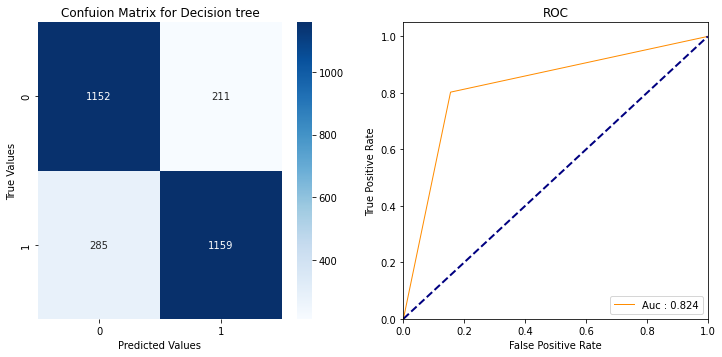

In [60]:
print ("\n Classification report for Decision tree \: \n",classification_report(validy,tree_clf.predict(validX)))


#confusion matrix
cm = confusion_matrix(validy,tree_clf.predict(validX))
plt.figure(figsize=(12,12))
plt.subplot(221)
sns.heatmap(cm, fmt = "d",annot=True, cmap='Blues')
plt.title('Confuion Matrix for Decision tree')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')


#roc_auc_score
model_roc_auc = roc_auc_score(validy,tree_clf.predict(validX)) 
print ("Area under curve : ",model_roc_auc,"\n")
fpr,tpr,thresholds = roc_curve(validy,tree_clf.predict(validX))

plt.subplot(222)
plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc : %.3f" %model_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

    
plt.show()

### Logistic Regression

In [61]:
lr = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
lr.fit(trainX, trainy)

LogisticRegression(C=1e+42, solver='liblinear')

In [62]:
print('intercept ', lr.intercept_[0])
print(pd.DataFrame({'coeff': lr.coef_[0]}, index=X.columns).transpose())

print('AIC', AIC_score(validy, lr.predict(validX), df = len(trainX.columns) + 1))

intercept  1.0833621553645938
       products_number  credit_card  active_member  country_Germany  \
coeff        -0.306953    -0.173466       -1.22963         0.600088   

       country_Spain  gender_Male  credit_score       age   tenure   balance  \
coeff      -0.393587    -0.759888     -0.009186  1.053379 -0.03515  0.184553   

       estimated_salary  
coeff          0.011039  
AIC 4113.562643057266


Positive correlations for factors like age and country Germany are linked to increased odds of a client leaving the bank. On the other hand, variables with negative coefficients are linked to staying in the bank, including having a strong credit score, a high wage, being an active member, and having a high credit score.


In [63]:
#Logistic Regression and tuning hyperparameters 
grid_parameters = {'C': [0.0001,0.001,0.01,0.1, 0.5, 1, 5, 10, 50, 100]}
lr= GridSearchCV(LogisticRegression(solver='liblinear',random_state=42), 
                 grid_parameters, cv=5, scoring="accuracy")
lr.fit(trainX,trainy)
lr_clf=lr.best_estimator_

In [64]:
#best parameters for logistic regression classifier
lr.best_params_

{'C': 0.01}

In [65]:
 # predictive performance on training data 
classificationSummary(trainy, lr_clf.predict(trainX))


Confusion Matrix (Accuracy 0.7350)

       Prediction
Actual    0    1
     0 4211 1454
     1 1520 4039



 Classification report for Logistic Regression \: 
               precision    recall  f1-score   support

           0       0.72      0.77      0.75      1363
           1       0.77      0.72      0.75      1444

    accuracy                           0.75      2807
   macro avg       0.75      0.75      0.75      2807
weighted avg       0.75      0.75      0.75      2807

Area under curve :  0.7477966864684591 



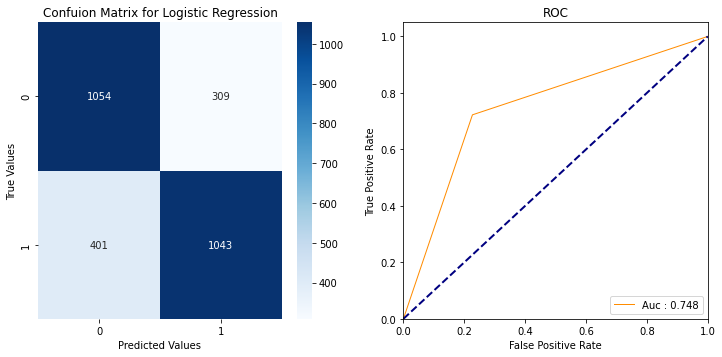

In [66]:
print ("\n Classification report for Logistic Regression \: \n",classification_report(validy,lr_clf.predict(validX)))


#confusion matrix
cm = confusion_matrix(validy,lr_clf.predict(validX))
plt.figure(figsize=(12,12))
plt.subplot(221)
sns.heatmap(cm, fmt = "d",annot=True, cmap='Blues')
plt.title('Confuion Matrix for Logistic Regression')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')


#roc_auc_score
model_roc_auc = roc_auc_score(validy,lr_clf.predict(validX)) 
print ("Area under curve : ",model_roc_auc,"\n")
fpr,tpr,thresholds = roc_curve(validy,lr_clf.predict(validX))

plt.subplot(222)
plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc : %.3f" %model_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

    
plt.show()

### XGBoost

In [67]:
# xgb and tuning hyperparameters 

xgb = GridSearchCV(XGBClassifier(),{'max_depth': [2,4,6,8,10],
                    'n_estimators': [50,100,200,250]}, 
                    verbose=1, 
                    scoring='neg_log_loss')

xgb.fit(trainX,trainy)
xgb_clf=xgb.best_estimator_


Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [68]:
#best parameters for xgboost classifier
xgb.best_params_

{'max_depth': 6, 'n_estimators': 100}

In [69]:
 # predictive performance on training data 
classificationSummary(trainy, xgb_clf.predict(trainX))

Confusion Matrix (Accuracy 0.9658)

       Prediction
Actual    0    1
     0 5565  100
     1  284 5275



 Classification report for XGBoost \: 
               precision    recall  f1-score   support

           0       0.87      0.93      0.90      1363
           1       0.93      0.86      0.90      1444

    accuracy                           0.90      2807
   macro avg       0.90      0.90      0.90      2807
weighted avg       0.90      0.90      0.90      2807

Area under curve :  0.8990969793290423 



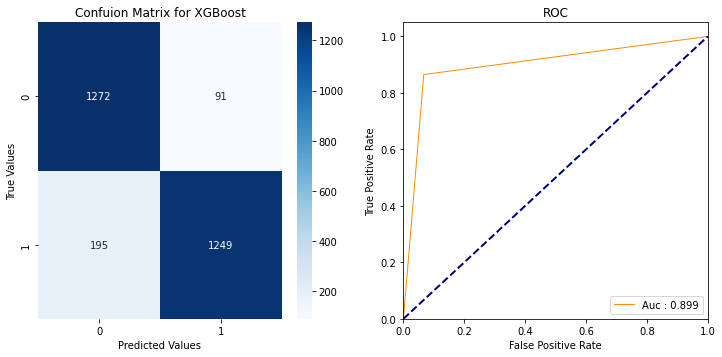

In [70]:
print ("\n Classification report for XGBoost \: \n",classification_report(validy,xgb_clf.predict(validX)))


#confusion matrix
cm = confusion_matrix(validy,xgb_clf.predict(validX))
plt.figure(figsize=(12,12))
plt.subplot(221)
sns.heatmap(cm, fmt = "d",annot=True, cmap='Blues')
plt.title('Confuion Matrix for XGBoost')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')


#roc_auc_score
model_roc_auc = roc_auc_score(validy,xgb_clf.predict(validX)) 
print ("Area under curve : ",model_roc_auc,"\n")
fpr,tpr,thresholds = roc_curve(validy,xgb_clf.predict(validX))

plt.subplot(222)
plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc : %.3f" %model_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

    
plt.show()

### Support Vector machine (SVM)

In [71]:
# SVM and tuning hyperparameters 
grid_parameters = {'C': [0.1 , 1, 10,12,15,20,25], 
          'gamma': [0.001, 0.01, 1,5,10]}

model = SVC()
svc= GridSearchCV(SVC(probability=True), grid_parameters)
svc.fit(trainX, trainy)
svc_clf=svc.best_estimator_

In [72]:
#best parameters for support vector classifier
svc.best_params_

{'C': 20, 'gamma': 1}

In [73]:
 # predictive performance on training data 
classificationSummary(trainy, svc_clf.predict(trainX))

Confusion Matrix (Accuracy 0.9989)

       Prediction
Actual    0    1
     0 5656    9
     1    3 5556



 Classification report for SVM \: 
               precision    recall  f1-score   support

           0       0.91      0.87      0.89      1363
           1       0.88      0.92      0.90      1444

    accuracy                           0.90      2807
   macro avg       0.90      0.90      0.90      2807
weighted avg       0.90      0.90      0.90      2807

Area under curve :  0.8955342825728646 



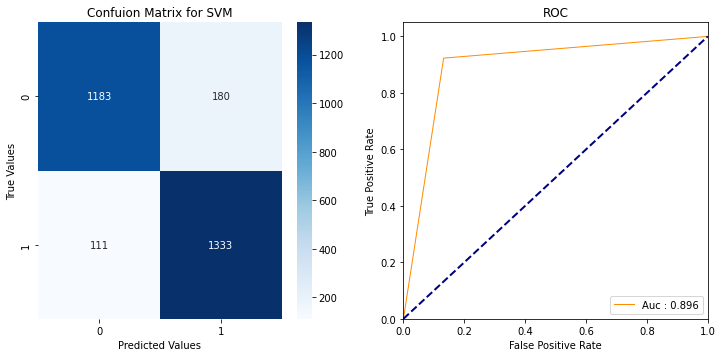

In [74]:
print ("\n Classification report for SVM \: \n",classification_report(validy,svc_clf.predict(validX)))


#confusion matrix
cm = confusion_matrix(validy,svc_clf.predict(validX))
plt.figure(figsize=(12,12))
plt.subplot(221)
sns.heatmap(cm, fmt = "d",annot=True, cmap='Blues')
plt.title('Confuion Matrix for SVM')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')


#roc_auc_score
model_roc_auc = roc_auc_score(validy,svc_clf.predict(validX)) 
print ("Area under curve : ",model_roc_auc,"\n")
fpr,tpr,thresholds = roc_curve(validy,svc_clf.predict(validX))

plt.subplot(222)
plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc : %.3f" %model_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

    
plt.show()

## Testing the models on test data set

### K-NN

0.8576010262989096
[[647 120]
 [102 690]]
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       767
           1       0.85      0.87      0.86       792

    accuracy                           0.86      1559
   macro avg       0.86      0.86      0.86      1559
weighted avg       0.86      0.86      0.86      1559



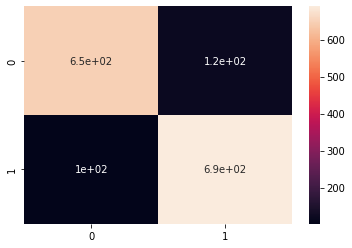

In [75]:
#test the model
test1=knn_clf.predict(testX)
print(accuracy_score(testy, test1))

#Confusion matrix
cm=confusion_matrix(testy,test1)
print(cm)
sns.heatmap(cm,annot=True)

print(classification_report(testy, test1))

### Random Forest

0.8133418858242463
[[654 113]
 [178 614]]
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       767
           1       0.84      0.78      0.81       792

    accuracy                           0.81      1559
   macro avg       0.82      0.81      0.81      1559
weighted avg       0.82      0.81      0.81      1559



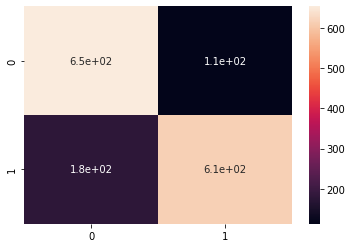

In [76]:
#test the model
test2=rf_clf.predict(testX)
print(accuracy_score(testy, test2))

#Confusion matrix
cm=confusion_matrix(testy,test2)
print(cm)
sns.heatmap(cm,annot=True)

print(classification_report(testy, test2))

### Decision Tree

0.8306606799230276
[[657 110]
 [154 638]]
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       767
           1       0.85      0.81      0.83       792

    accuracy                           0.83      1559
   macro avg       0.83      0.83      0.83      1559
weighted avg       0.83      0.83      0.83      1559



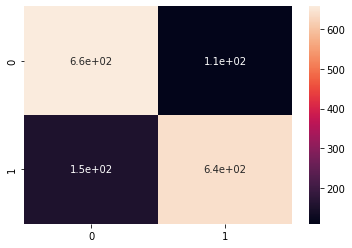

In [77]:
#test the model
test3=tree_clf.predict(testX)
print(accuracy_score(testy, test3))

#Confusion matrix
cm=confusion_matrix(testy,test3)
print(cm)
sns.heatmap(cm,annot=True)

print(classification_report(testy, test3))

### Logistic regression

0.7241821680564464
[[566 201]
 [229 563]]
              precision    recall  f1-score   support

           0       0.71      0.74      0.72       767
           1       0.74      0.71      0.72       792

    accuracy                           0.72      1559
   macro avg       0.72      0.72      0.72      1559
weighted avg       0.72      0.72      0.72      1559



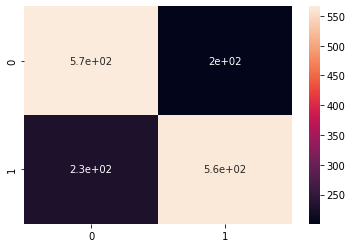

In [78]:
#test the model
test4=lr_clf.predict(testX)
print(accuracy_score(testy, test4))

#Confusion matrix
cm=confusion_matrix(testy,test4)
print(cm)
sns.heatmap(cm,annot=True)

print(classification_report(testy, test4))

### XGBoost

0.8992944194996793
[[714  53]
 [104 688]]
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       767
           1       0.93      0.87      0.90       792

    accuracy                           0.90      1559
   macro avg       0.90      0.90      0.90      1559
weighted avg       0.90      0.90      0.90      1559



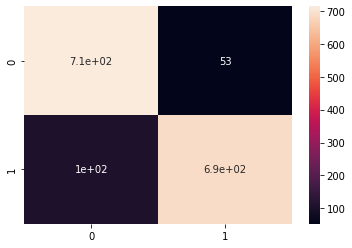

In [79]:
#test the model
test5=xgb_clf.predict(testX)
print(accuracy_score(testy, test5))

#Confusion matrix
cm=confusion_matrix(testy,test5)
print(cm)
sns.heatmap(cm,annot=True)

print(classification_report(testy, test5))

### SVM

0.8986529826812059
[[661 106]
 [ 52 740]]
              precision    recall  f1-score   support

           0       0.93      0.86      0.89       767
           1       0.87      0.93      0.90       792

    accuracy                           0.90      1559
   macro avg       0.90      0.90      0.90      1559
weighted avg       0.90      0.90      0.90      1559



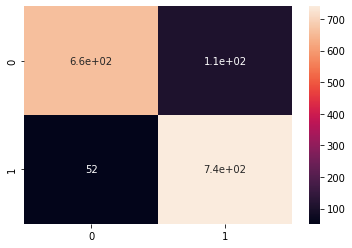

In [80]:
#test the model
test6=svc_clf.predict(testX)
print(accuracy_score(testy, test6))

#Confusion matrix
cm=confusion_matrix(testy,test6)
print(cm)
sns.heatmap(cm,annot=True)

print(classification_report(testy, test6))

## ROC Curve Comparision 

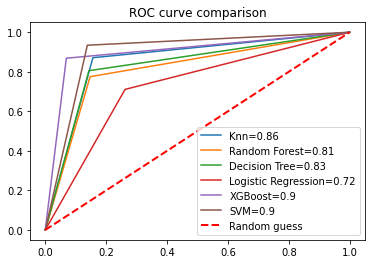

In [117]:
plt.figure().clf()
fpr, tpr,_ = metrics.roc_curve(testy, test1)
auc = metrics.roc_auc_score(testy, test1)
plt.plot(fpr,tpr,label="Knn="+str(round(auc,2)))
fpr, tpr,_ = metrics.roc_curve(testy, test2)
auc = metrics.roc_auc_score(testy, test2)
plt.plot(fpr,tpr,label="Random Forest="+str(round(auc,2)))
fpr, tpr,_ = metrics.roc_curve(testy, test3)
auc = metrics.roc_auc_score(testy, test3)
plt.plot(fpr,tpr,label="Decision Tree="+str(round(auc,2)))
fpr, tpr,_ = metrics.roc_curve(testy, test4)
auc = metrics.roc_auc_score(testy, test4)
plt.plot(fpr,tpr,label="Logistic Regression="+str(round(auc,2)))
fpr, tpr,_ = metrics.roc_curve(testy, test5)
auc = metrics.roc_auc_score(testy, test5)
plt.plot(fpr,tpr,label="XGBoost="+str(round(auc,2)))
fpr, tpr,_ = metrics.roc_curve(testy, test6)
auc = metrics.roc_auc_score(testy, test6)
plt.plot(fpr,tpr,label="SVM="+str(round(auc,2)))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
plt.title("ROC curve comparison")
plt.legend(loc=0)

### Examine the predictive performance of the models using gain chart

AttributeError: 'numpy.ndarray' object has no attribute 'get_figure'

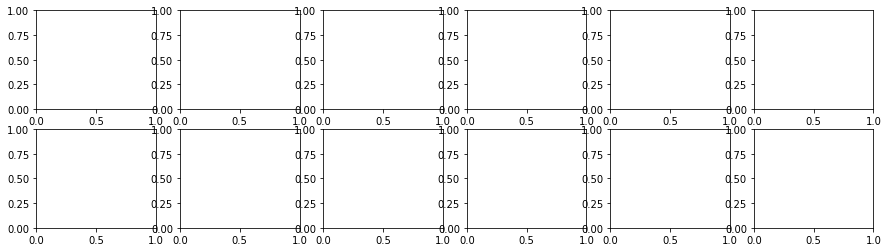

In [92]:
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(15, 4))

def modelGainsChart(model, title, ax=None):
    result = pd.DataFrame({
        'actual': validy,
        'prob': model.predict_proba(validX)[:, 1]
    })

    result = result.sort_values(by=['prob'], ascending=False).reset_index(drop=True)
    ax = gainsChart(result.actual, ax=ax)
    ax.set_title(title)
    return ax

modelGainsChart(knn_clf, 'K-NN', axes[0])
modelGainsChart(lr_clf, 'Logistic regression', axes[1])
modelGainsChart(tree_clf, 'Decision tree', axes[2])
modelGainsChart(rf_clf, 'Random forest', axes[3])
modelGainsChart(xgb_clf, 'XGBoost', axes[4])
modelGainsChart(svc, 'Support vector machine', axes[5])



ax = modelGainsChart(lr_clf, 'Logistic regression')

modelGainsChart(knn_clf, 'K-NN', ax)
modelGainsChart(rf_clf, 'Random forest', ax)
modelGainsChart(tree_clf, 'Decision tree', ax)
modelGainsChart(xgb_clf, 'XGBosst', ax)
modelGainsChart(svc, 'Support vector machine', ax)


ax.set_title('All models')

### Important features of the best model (XG-Boost)

Text(0.5, 1.0, 'Feature Importance Ranking Related to The Best Model (XG-Boost)')

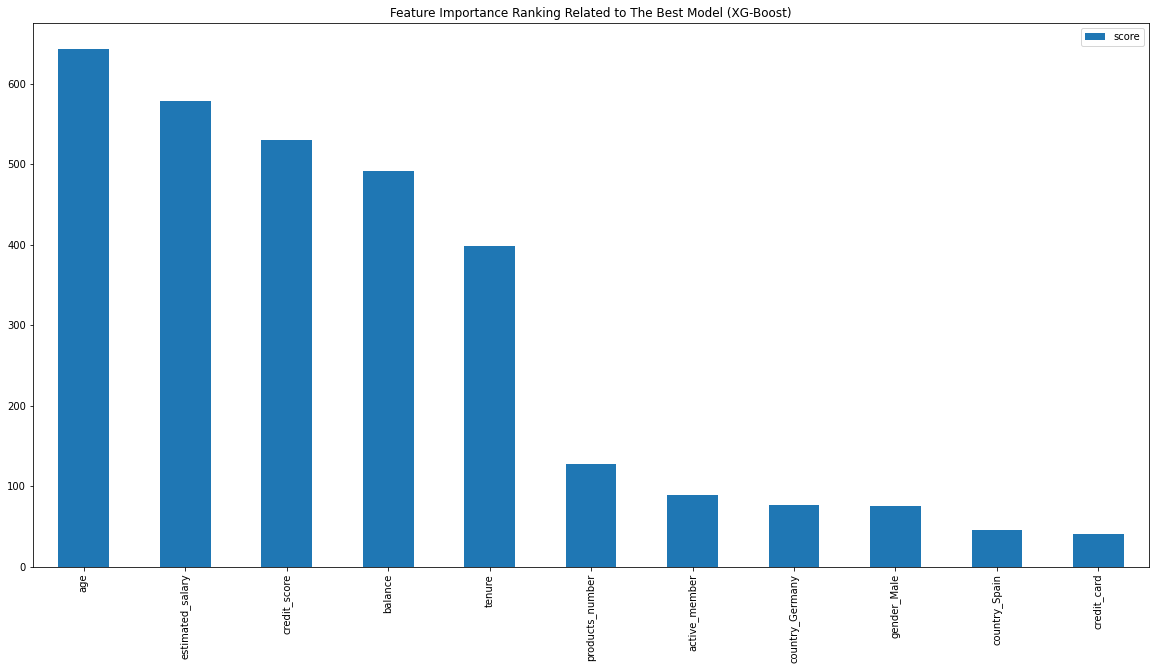

In [83]:
# fit the XGBoost model using the best parameters
best_clf=XGBClassifier(max_depth=6,n_estimators=100)
best_clf.fit(trainX,trainy)
feature_important = best_clf.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='bar', figsize = (20,10)) ## plot top 40 features
plt.title('Feature Importance Ranking Related to The Best Model (XG-Boost)')

### Models Evaluation Comparision

In [103]:
# Logistic regression evaluation metrics
lr_report = classification_report(validy,lr_clf.predict(validX), output_dict=True)
lr_accuracy = round(lr_report['accuracy'],3)
lr_precision = round(lr_report['1']['precision'],3)
lr_recall = round(lr_report['1']['recall'],3)
lr_f1score = round(lr_report['1']['f1-score'],3)

In [118]:
# K-NN evaluation metrics
knn_report = classification_report(validy,knn_clf.predict(validX), output_dict=True)
knn_accuracy = round(knn_report['accuracy'],3)
knn_precision = round(knn_report['1']['precision'],3)
knn_recall = round(knn_report['1']['recall'],3)
knn_f1score = round(knn_report['1']['f1-score'],3)

In [119]:
# Random Forest evaluation metrics
rf_report = classification_report(validy,rf_clf.predict(validX), output_dict=True)
rf_accuracy = round(rf_report['accuracy'],3)
rf_precision = round(rf_report['1']['precision'],3)
rf_recall = round(rf_report['1']['recall'],3)
rf_f1score = round(rf_report['1']['f1-score'],3)

In [122]:
# Decision Tree evaluation metrics
dt_report = classification_report(validy,tree_clf.predict(validX), output_dict=True)
dt_accuracy = round(dt_report['accuracy'],3)
dt_precision = round(dt_report['1']['precision'],3)
dt_recall = round(dt_report['1']['recall'],3)
dt_f1score = round(dt_report['1']['f1-score'],3)

In [123]:
# XGBoost evaluation metrics
xgb_report = classification_report(validy,xgb_clf.predict(validX), output_dict=True)
xgb_accuracy = round(xgb_report['accuracy'],3)
xgb_precision = round(xgb_report['1']['precision'],3)
xgb_recall = round(xgb_report['1']['recall'],3)
xgb_f1score = round(xgb_report['1']['f1-score'],3)

In [124]:
# XGBoost evaluation metrics
svm_report = classification_report(validy,svc_clf.predict(validX), output_dict=True)
svm_accuracy = round(svm_report['accuracy'],3)
svm_precision = round(svm_report['1']['precision'],3)
svm_recall = round(svm_report['1']['recall'],3)
svm_f1score = round(svm_report['1']['f1-score'],3)

In [128]:
models_evaluation_comparision = pd.DataFrame({'Model':["Logistic Regression","KNN","Random Forest",
                                                      "Decision Tree","XGBoost","Support Vector Machine (SVM)"],
                                             "Accuracy Score": [lr_accuracy, knn_accuracy,rf_accuracy,
                                                                dt_accuracy,xgb_accuracy,svm_accuracy],
                                              
                                             "Precision Score":[lr_precision, knn_precision,rf_precision,
                                                                dt_precision,xgb_precision,svm_precision],
                                              
                                              "Recall Score": [lr_recall, knn_recall, rf_recall, 
                                                              dt_recall,xgb_recall,svm_recall],
                                              
                                              "F1 Score":[lr_f1score, knn_f1score,rf_f1score,
                                                         dt_f1score,xgb_f1score,svm_f1score]})

models_evaluation_comparision.sort_values(by=("Accuracy Score"),ascending=False)

,Model,Accuracy Score,Precision Score,Recall Score,F1 Score
4,XGBoost,0.898,0.932,0.865,0.897
5,Support Vector Machine (SVM),0.896,0.881,0.923,0.902
1,KNN,0.862,0.858,0.877,0.867
2,Random Forest,0.824,0.859,0.787,0.821
3,Decision Tree,0.823,0.846,0.803,0.824
0,Logistic Regression,0.747,0.771,0.722,0.746


### Use the final model on unseen dataset (X_test)

In [84]:
testing_df = testX.copy()
testing_df['Probabilities'] = xgb_clf.predict_proba(testX)[:, 1]
testing_df['Prediction'] = xgb_clf.predict(testX)

In [85]:
# predictions on unseen data
churn = testing_df[testing_df['Prediction']==0].shape[0]
no_churn = testing_df[testing_df['Prediction']==1].shape[0]

print(f'Churn: {churn}')
print(f'No Churn: {no_churn}')
print(f'Churn Rate: {churn/testing_df.shape[0]}')

Churn: 818
No Churn: 741
Churn Rate: 0.5246953175112251


<b>The XGBoost outperforms all other models with accuracy values of 0.96, precision values of 0.93, recall values of 0.87, and F1 scores of 0.90. Among all the variables, the AUC rate, which has a value of 0.899, has the highest rate.</b>